# I will use the following notebook to demonstrate different steps in preprocessing

These steps will include:
1) Slice timing correction
2) Motion correction
3) Coregistration
4) Spatial and temporal filtering

In [1]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# I next want to get a list of all of my functional files

In [2]:
sid = ['021']
base_dir = '/home/mrive301/Documents/CogNeuro_Methods/CogNeuro_proj'
work_dir = '/scratch/madlab/mvrn_cogneuro'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/func')

# Get a list of my localizer json and nifti converted files
localizer_func_json = sorted(glob(func_dir + '/*localizer*.json'))
localizer_func_files = sorted(glob(func_dir + '/*localizer*.nii.gz'))

# Get a list of my study task json and nifti converted files
study_func_json = sorted(glob(func_dir + '/*study*.json'))
study_func_files = sorted(glob(func_dir + '/*study*.nii.gz'))

In [3]:
'''
========================================================
Creating function to eliminate mapnode directory structure 
and saving output func_filed in a dingle directory
========================================================
'''
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

'''
========================================================
Receiving text file with number of outliers per volume. Then,
we find which volume index has the least number of outliers.

We search over the first 201 volumes.

If index returns list, that's becaus there were multiple
volumes wih the same number of outliers. If so, we pick the 
first one.
========================================================
'''

def best_vol(outlier_count):
    #Searching over 201 volumes which one has the least number of 
        #outliers. If best one found, we return such one. 
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    #If not, and all have same number of outliers, we return first one
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

'''
========================================================
Creating list with ST for each study run
========================================================
'''
slice_timing_list = []
for curr_json in study_func_json:
    curr_json_data = open(curr_json) #opening json with func data
    curr_study_func_metadata = json.load(curr_json_data) #loading json files
    #Appending functional json files with "ST" name
    slice_timing_list.append(curr_study_func_metadata['SliceTiming'])

# Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [ ]:
'''
========================================================
Creating function to eliminate mapnode directory structure 
and saving output func_filed in a dingle directory
========================================================
'''
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

'''
========================================================
Receiving text file with number of outliers per volume. Then,
we find which volume index has the least number of outliers.

We search over the first 201 volumes.

If index returns list, that's becaus there were multiple
volumes wih the same number of outliers. If so, we pick the 
first one.
========================================================
'''

def best_vol(outlier_count):
    #Searching over 201 volumes which one has the least number of 
        #outliers. If best one found, we return such one. 
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    #If not, and all have same number of outliers, we return first one
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

'''
========================================================
Creating list with ST for each study run
========================================================
'''
slice_timing_list = []
for curr_json in study_func_json:
    curr_json_data = open(curr_json) #opening json with func data
    curr_study_func_metadata = json.load(curr_json_data) #loading json files
    #Appending functional json files with "ST" name
    slice_timing_list.append(curr_study_func_metadata['SliceTiming'])

# Establishing a nipype work flow that I will eventually execute
cogneuro_wf = pe.Workflow(name='cogneuro_wf')

'''
========================================================
The following contributes to the function above that 
eliminates the mapnode by substituting the "func_files" 
name with "subs". 
========================================================
'''
# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                              output_names=['subs'],
                              function=get_subs),
                              name='getsubs')
getsubs.inputs.func_files = study_func_files

'''
========================================================
Using 3dToutcount to find the number of outliers per vol.
This is allowing us to create our basis for motion correction
by selecting the first volume with the lowest outlier number.
========================================================
'''
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
id_outliers.inputs.in_file = study_func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

'''
========================================================
Passig the node that will allow us to get the best volume (the
one with the min number of outliers). This is based on 
previous outlier function above.
========================================================
'''
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                                  output_names=['best_vol_num'],
                                  function=best_vol),
                                   name='getbestvol')
cogneuro_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

'''
========================================================
Extracting earliest volume of the first run as our reference
image.
========================================================
'''
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
extractref.inputs.in_file = study_func_files[0]
#extractref.inputs.t_min = int(np.ceil(nb.load(study_func_files[0]).shape[3]/2)) #PICKING MIDDLE
cogneuro_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

'''
=============================================================
Aaron's question: Would I want to do slice timing correction here?
Why? Why not?
Answer: No, you want to do so aftr motion correction, otherwise 
you may have motion intensity differences propagated across time.

=============================================================
'''
'''
=============================================================
Running AFNIs 3dTshift to do ST correction. We input the 
functional files as a list, along with the ST as a list of lists. We
use a mapnode to iterate over the two so we can run them
at the same time on the HPC.
=============================================================
'''

tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
tshifter.inputs.in_file = study_func_files
tshifter.inputs.tr = str(curr_study_func_metadata['RepetitionTime'])
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'

'''
=============================================================
Running AFNI's 3dvolreg for motion correction. We iterate over
our functional files which we pass functional data from the
slice timing correction node before we use the earliest volume with
the least number of outliers during the first run
as the base file to register to.
=============================================================
'''
volreg = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
volreg.inputs.outputtype = 'NIFTI_GZ'
volreg.inputs.zpad = 4
cogneuro_wf.connect(tshifter, 'out_file', volreg, 'in_file')
cogneuro_wf.connect(extractref, 'roi_file', volreg, 'basefile')

# Below is the code if I wanted to use the FSL McFlirt command
'''
motion_corr = pe.MapNode(fsl.MCFLIRT(),
                         iterfield=['in_file'],
                         name = 'motion_corr')
motion_corr.inputs.output_type = 'NIFTI_GZ'
cogneuro_wf.connect(tshifter, 'out_file', motion_corr, 'in_file')
cogneuro_wf.connect(extractref, 'roi_file', motion_corr, 'ref_file')
'''

'''
=============================================================
Sinking data!
=============================================================
'''
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives')
datasink.inputs.container = f'sub-{sid[0]}'
cogneuro_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')
cogneuro_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
cogneuro_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')
cogneuro_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')
cogneuro_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
cogneuro_wf.connect(getsubs, 'subs', datasink, 'substitutions')

# The following two lines set a work directory outside of my 
# local git repo and runs the workflow
cogneuro_wf.base_dir = work_dir + f'/cogneuroworkdir/sub-{sid[0]}'
cogneuro_wf.run()

# Now I will load and plot the motion files

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


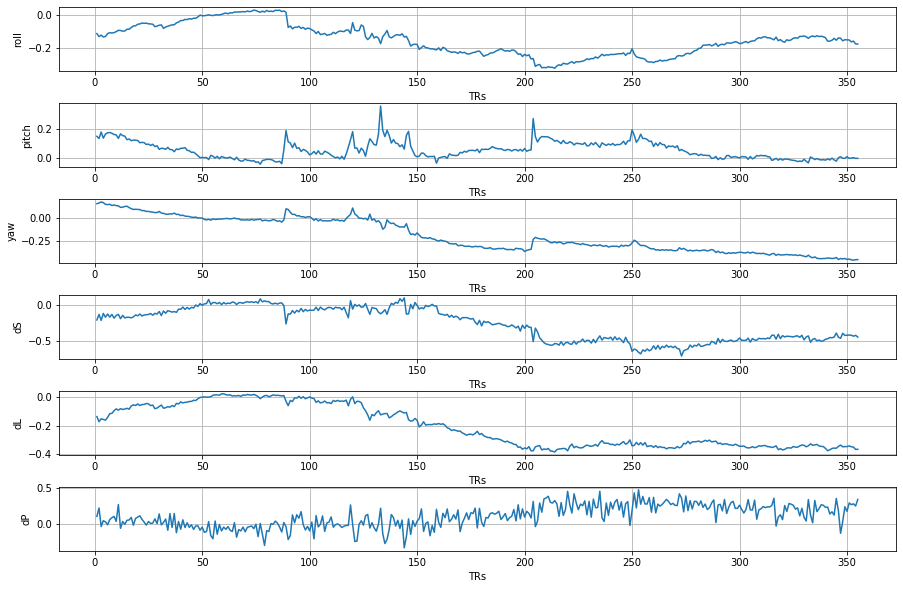

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


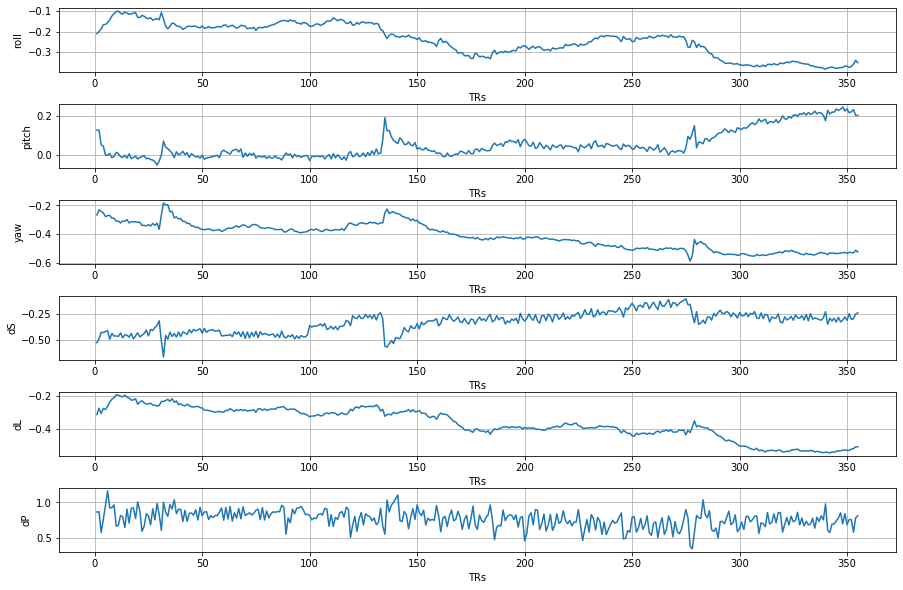

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


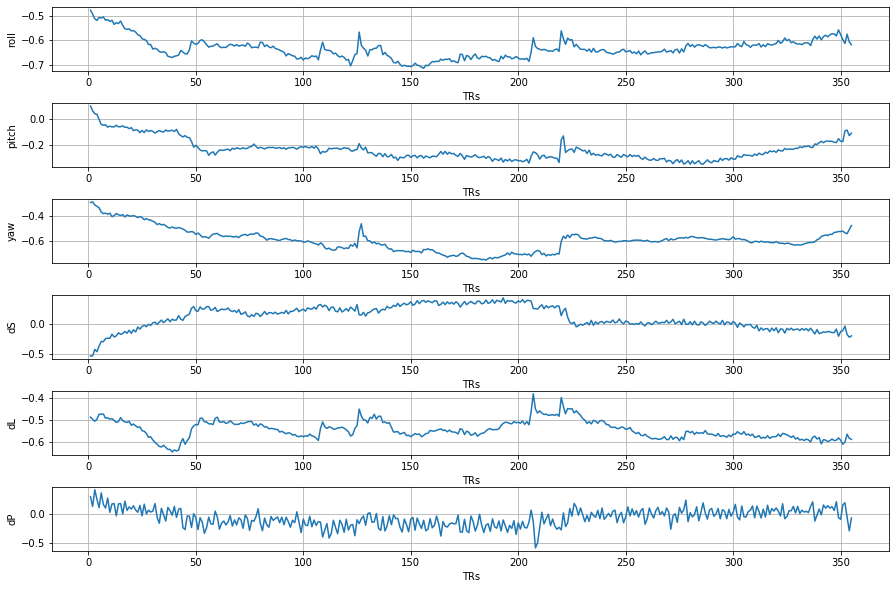

/home/data/madlab/envs/emuR01_madlab_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


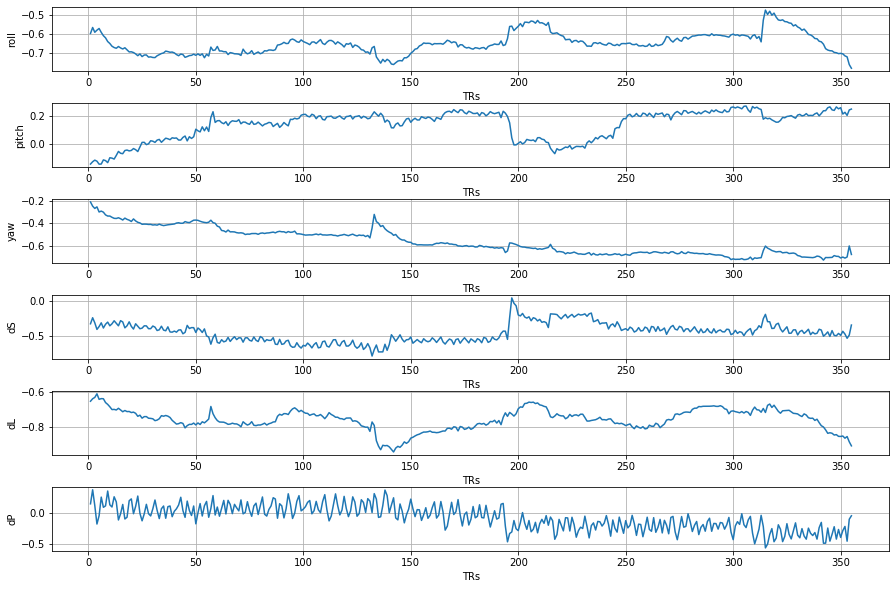

In [5]:
motion_dir = os.path.join(base_dir, f'derivatives/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*study*_tshift.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

In [6]:
study_motcorr_files = sorted(glob(motion_dir + '/*.nii.gz'))
study_motcorr_img_data = nb.load(study_motcorr_files[0]).get_fdata()
study_orig_img_data = nb.load(study_func_files[0]).get_fdata()

#test_motcorr_img_data.shape

print(study_motcorr_img_data[50,50,32,50])
print(study_orig_img_data[50,50,32,50])

134.0
129.0
